In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import bilby
import pandas as pd
import scipy
import joblib
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import astropy
import matplotlib.patches as mpatches
from concurrent.futures import ProcessPoolExecutor
from itertools import product
import matplotlib.gridspec as gridspec

In [99]:
SMALL_SIZE = 15+5
MEDIUM_SIZE = 20+5
BIGGER_SIZE = 25+5

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

In [2]:
duration = 4
sampling_frequency = 2048
t0_gps = 1126259460.4
gps_time = t0_gps + duration/2

delta = 10
ras = np.radians(np.arange(0, 360, delta))
decs = np.radians(np.arange(-90, 90, delta))
ra_s = np.linspace(0, 2*np.pi, 1000)
dec_s = np.linspace(-np.pi/2, np.pi/2, 1000)
RA, DEC = np.meshgrid(ra_s, dec_s)
psis = np.linspace(-np.pi, np.pi, 50)

In [152]:
def whiten(strain_df, psd_df):
    return strain_df['h'] / np.sqrt(psd_df['PSD'])

def match_filter(strain_df, waveform_df, IFO, sampling_frequency=sampling_frequency, gps_time=gps_time):
    mask = strain_df['Hz'] > 20
    S = IFO.power_spectral_density.psd_array
    S[~mask] = np.inf
    best_rhosq = 0
    df = waveform_df['Hz'][1] - waveform_df['Hz'][0]
    waveform_dict = {col: waveform_df[col].values for col in waveform_df.columns}
    strain_dict = {col: strain_df[col].values for col in strain_df.columns}

    for ra in ras:
        for dec in decs:
            for psi in psis:
                fplus = IFO.antenna_response(ra, dec, gps_time, psi, 'plus')
                fcross = IFO.antenna_response(ra, dec, gps_time, psi, 'cross')
                template = fplus*waveform_dict['h+'] + fcross*waveform_dict['hx']
                Z = strain_dict['h']*np.conj(template)/S
                # template = fplus*waveform_df['h+'] + fcross*waveform_df['hx']
                # Z = strain_df['h']*np.conj(template)/S
                Z[np.isnan(Z)] = 0
                rhosq = 4*np.fft.ifft(Z, n=(2*len(Z)-2)).real*sampling_frequency
                N = np.sqrt(4*np.sum(np.abs(template)**2/S) * df)
                rhosq /= N
                real_rhosq = rhosq.real
                if np.max(real_rhosq) > best_rhosq:
                    best_rhosq = np.max(real_rhosq)
                    best_ra = ra
                    best_dec = dec
                    best_rhosqs = real_rhosq
                    best_psi = psi
                
    return best_rhosq, best_ra, best_dec, best_psi, best_rhosqs

def get_tc(snr, time):
    peak_idx = np.argmax(np.abs(snr))
    peak_time = time[peak_idx]
    peak_val = np.abs(snr[peak_idx])
    half_max = peak_val / 2

    left_idx = peak_idx
    while left_idx > 0 and np.abs(snr)[left_idx] > half_max:
        left_idx -= 1
    t1 = np.interp(half_max, 
                   [np.abs(snr)[left_idx], np.abs(snr)[left_idx + 1]],
                   [time[left_idx], time[left_idx + 1]])

    # Right side of the peak
    right_idx = peak_idx
    while right_idx < len(np.abs(snr)) - 1 and np.abs(snr)[right_idx] > half_max:
        right_idx += 1

    t2 = np.interp(half_max, 
                   [np.abs(snr)[right_idx - 1], np.abs(snr)[right_idx]],
                   [time[right_idx - 1], time[right_idx]])


    fwhm = t2 - t1
    sigma = fwhm / 2.355

    return peak_time, sigma, fwhm, t1, t2

def snr_plots(time, tcs, errs, snrs, t1s, t2s, title):
    labels = ['H1', 'L1', 'V1']
    colors = ['#0072B2', '#E69F00', '#CC79A7']
    ratios = [1 for _ in range(len(tcs)+1)]

    fig, ax = plt.subplots(len(tcs)+1, 1, figsize=(12, 3*(len(tcs)+1)), sharex=True, gridspec_kw={'height_ratios': ratios, 'hspace': 0})
    for i, (tc, err, snr, t1, t2, label, color) in enumerate(zip(tcs, errs, snrs, t1s, t2s, labels, colors)):
        ax[i+1].plot(time, np.abs(snr), label=f'$t_c^\mathrm{{({label})}}$ = {tc:.3f}s ± {err:.4f}s', color=color)
        ax[i+1].axvline(tc, color=color, linestyle='--')
        ax[i+1].axvspan(t1, t2, color=color, alpha=0.3)
        ax[i+1].set_ylabel('SNR')
        ax[i+1].legend()
        ax[i+1].grid()
        ax[i+1].set_xlim(2, 2.1)
        ax[0].plot(time, np.abs(snr), label=f'$t_c^\mathrm{{({label})}}$ = {tc:.3f}s ± {err:.4f}s', color=color)
        ax[0].axvline(tc, color=color, linestyle='--')
        ax[0].axvspan(t1, t2, color=color, alpha=0.3)
    ax[0].set_ylabel('SNR')
    ax[0].legend()
    ax[0].grid()
    ax[0].set_xlim(2, 2.1)
    ax[-1].set_xlabel('Time (s)')

    plt.savefig(f"figures/snr_{title}.png", bbox_inches='tight', dpi=300)
    plt.show()

def calculate_time_delay_grid(RA, DEC):
    """
    Calculate time delays for all sky positions using bilby's method
    """
    
    time_delays_HLV = np.zeros(shape=(RA.shape[0], RA.shape[1], 3))
    
    for i in range(len(DEC)):
        for j in range(len(RA)):
            ra = RA[i, j]
            dec = DEC[i, j]
            
            h1_delay = IFOH.time_delay_from_geocenter(ra, dec, gps_time)
            l1_delay = IFOL.time_delay_from_geocenter(ra, dec, gps_time)
            v1_delay = IFOV.time_delay_from_geocenter(ra, dec, gps_time)
            
            time_delays_HLV[i, j, 0] = h1_delay - l1_delay  # H1-L1
            time_delays_HLV[i, j, 1] = h1_delay - v1_delay  # H1-V1
            time_delays_HLV[i, j, 2] = v1_delay - l1_delay  # V1-L1
    
    return time_delays_HLV

def get_likelihood(detector_delays, measured_delays, sigmas):
    """
    Calculate the likelihood for the given time delays and measured delays
    """
    likelihood = []

    for i in range(len(sigmas)):
        likelihood.append(np.exp(-0.5*(detector_delays.T[i].T - measured_delays[i])**2 / sigmas[i]**2))

    prob_hlv = likelihood[0] * likelihood[1] * likelihood[2]

    likelihood.append(prob_hlv)
    
    return likelihood

def detector_skymap(detector_delays, measured_delays, sigmas):
    masks = np.zeros(shape=np.array(detector_delays).shape, dtype=bool)
    for i, (detector_delay, measured_delay, sigma) in enumerate(zip(detector_delays.T, measured_delays, sigmas)):
        mask = np.abs(detector_delay.T - measured_delay) <= sigma
        masks[:,:,i] = mask
    combined = masks.T[0].T & masks.T[1].T & masks.T[2].T
    return masks, combined

def get_plots(detector_delays, measured_delays, sigmas):
    ra = np.linspace(0, 2*np.pi, 1000)
    dec = np.linspace(-np.pi/2, np.pi/2, 1000)
    RA, DEC = np.meshgrid(ra, dec)
    RA_moll = RA - 2*np.pi*(RA > np.pi)
    sort_idx = np.argsort(RA_moll[0])
    RA_sort = RA_moll[:, sort_idx]
    DEC_sort = DEC[:, sort_idx]
    prob = get_likelihood(detector_delays, measured_delays, sigmas)
    prob[0] = prob[0][:, sort_idx]
    prob[1] = prob[1][:, sort_idx]
    prob[2] = prob[2][:, sort_idx]
    prob[3] = prob[3][:, sort_idx]
    masks, combined = detector_skymap(detector_delays, measured_delays, sigmas)

    numeric_masks = [mask.T[:, sort_idx].astype(float) for mask in masks.T]
    numeric_combined = combined[:, sort_idx].astype(float)

    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(2, 1, 2, projection='mollweide')
    contour2 = ax.pcolormesh(RA_sort, DEC_sort, prob[0], cmap='Wistia', shading='auto')
    ax.contour(RA, DEC, masks.T[0].T, colors='black', linestyles='-', linewidths=2, zorder = 1)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', colors='black', labelsize=16)
    ax.set_xlabel("RA (deg)", fontsize=17)
    ax.set_ylabel("Dec (deg)", fontsize=17)
    ax.grid(True)
    cbar = fig.colorbar(contour2, ax=ax, orientation='vertical')
    cbar.set_label('Relative Likelihood', fontsize=18)
    cbar.ax.tick_params(labelsize=18)
    plt.savefig("figures/detector_skymap_HL.png", bbox_inches='tight', dpi=300)
    plt.show()
    

    levels=[0.5, 1.5]
    fig = plt.figure(figsize=(10, 13))
    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 0.05], hspace=0)
    ax1 = fig.add_subplot(gs[0], projection='mollweide')
    ax2 = fig.add_subplot(gs[1], projection='mollweide')
    cax = fig.add_subplot(gs[2])  

    ax1.contourf(RA_sort, DEC_sort, numeric_masks[0], levels=levels, alpha=0.4, colors='#1E88E5')
    ax1.contourf(RA_sort, DEC_sort, numeric_masks[1], levels=levels, alpha=0.4, colors='#004D40')
    ax1.contourf(RA_sort, DEC_sort, numeric_masks[2], levels=levels, alpha=0.4, colors='#FFC107')
    ax1.contour(RA_sort, DEC_sort, numeric_combined, levels=levels, colors='#D81B60', linestyles='-', linewidths=2, zorder = 1)
    ax1.tick_params(axis='x', labelsize=18)
    ax1.tick_params(axis='y', colors='black', labelsize=16)
    # ax1.set_xlabel("RA (deg)", fontsize=17)
    ax1.set_ylabel("Dec (deg)", fontsize=17)
    handles = [mpatches.Patch(color=color, alpha=0.3, label=name) for color, name in zip(['#1E88E5', '#004D40', '#FFC107'], ['H1', 'L1', 'V1'])]
    handles.append(mpatches.Patch(color='#D81B60', label='H1 & L1 & V1'))
    ax1.grid(True)
    ax1.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=4, fontsize=14, frameon=False)
    
    contour2 = ax2.pcolormesh(RA_sort, DEC_sort, prob[3], cmap='Wistia', shading='auto')
    ax2.contour(RA, DEC, combined, colors='black', linestyles='-', linewidths=2, zorder = 1)
    ax2.tick_params(axis='x', labelsize=18)
    ax2.tick_params(axis='y', colors='black', labelsize=16)
    ax2.set_xlabel("RA (deg)", fontsize=17)
    ax2.set_ylabel("Dec (deg)", fontsize=17)
    
    fig.colorbar(contour2, cax=cax, orientation='horizontal')
    cax.set_xlabel('Relative Likelihood', fontsize=18)
    cax.tick_params(labelsize=18)

    ax2.grid(True)
    plt.savefig("figures/detector_skymap_intersection.png", bbox_inches='tight', dpi=300)
    plt.show()
    

<>:71: SyntaxWarning: invalid escape sequence '\m'
<>:78: SyntaxWarning: invalid escape sequence '\m'
<>:71: SyntaxWarning: invalid escape sequence '\m'
<>:78: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_114487/2799989177.py:71: SyntaxWarning: invalid escape sequence '\m'
  ax[i+1].plot(time, np.abs(snr), label=f'$t_c^\mathrm{{({label})}}$ = {tc:.3f}s ± {err:.4f}s', color=color)
/tmp/ipykernel_114487/2799989177.py:78: SyntaxWarning: invalid escape sequence '\m'
  ax[0].plot(time, np.abs(snr), label=f'$t_c^\mathrm{{({label})}}$ = {tc:.3f}s ± {err:.4f}s', color=color)


In [69]:
waveform = np.loadtxt('data/waveform.txt')
h1_strain = np.loadtxt('data/H1_strain.txt')
l1_strain = np.loadtxt('data/L1_strain.txt')
v1_strain = np.loadtxt('data/V1_strain.txt')
h1_psd = np.loadtxt('data/H1_psd.txt')
l1_psd = np.loadtxt('data/L1_psd.txt')
v1_psd = np.loadtxt('data/V1_psd.txt')

In [6]:
waveform = pd.DataFrame(data=waveform, columns=['Hz', 'Re(h+)', 'Im(h+)', 'Re(hx)', 'Im(hx)'])

h1_strain = pd.DataFrame(data=h1_strain, columns=['Hz', 'Re(h)', 'Im(h)'])
l1_strain = pd.DataFrame(data=l1_strain, columns=['Hz', 'Re(h)', 'Im(h)'])
v1_strain = pd.DataFrame(data=v1_strain, columns=['Hz', 'Re(h)', 'Im(h)'])

h1_psd = pd.DataFrame(data=h1_psd, columns=['Hz', 'PSD'])
l1_psd = pd.DataFrame(data=l1_psd, columns=['Hz', 'PSD'])
v1_psd = pd.DataFrame(data=v1_psd, columns=['Hz', 'PSD'])

In [7]:
IFOH = bilby.gw.detector.InterferometerList(['H1'])[0]
IFOH.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=h1_psd['Hz'].values, psd_array=h1_psd['PSD'].values)

IFOL = bilby.gw.detector.InterferometerList(['L1'])[0]
IFOL.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=l1_psd['Hz'].values, psd_array=l1_psd['PSD'].values)

IFOV = bilby.gw.detector.InterferometerList(['V1'])[0]
IFOV.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=v1_psd['Hz'].values, psd_array=v1_psd['PSD'].values)

In [38]:
waveform['h+'] = waveform['Re(h+)'] + 1j*waveform['Im(h+)']
waveform['hx'] = waveform['Re(hx)'] + 1j*waveform['Im(hx)']

h1_strain['h'] = h1_strain['Re(h)'] + 1j*h1_strain['Im(h)']
l1_strain['h'] = l1_strain['Re(h)'] + 1j*l1_strain['Im(h)']
v1_strain['h'] = v1_strain['Re(h)'] + 1j*v1_strain['Im(h)']

snr_H1 = match_filter(h1_strain, waveform, IFOH)[-1]
snr_L1 = match_filter(l1_strain, waveform, IFOL)[-1]
snr_V1 = match_filter(v1_strain, waveform, IFOV)[-1]

time = np.arange(len(snr_H1)) / sampling_frequency

tc_H1, sigma_H1, fwhm_H1, t1_H1, t2_H2 = get_tc(snr_H1, time)
tc_L1, sigma_L1, fwhm_L1, t1_L1, t2_L2 = get_tc(snr_L1, time)
tc_V1, sigma_V1, fwhm_V1, t1_V1, t2_V2 = get_tc(snr_V1, time)

files = {
    'waveform': waveform,
    'h1_strain': h1_strain,
    'l1_strain': l1_strain,
    'v1_strain': v1_strain,
    'h1_psd': h1_psd,
    'l1_psd': l1_psd,
    'v1_psd': v1_psd,
}

data = {}

for name, df in files.items():
    data[name] = {col: df[col].values for col in df.columns}

joblib.dump(data, 'data/data.pkl')

time_delays_HLV = calculate_time_delay_grid(RA, DEC)

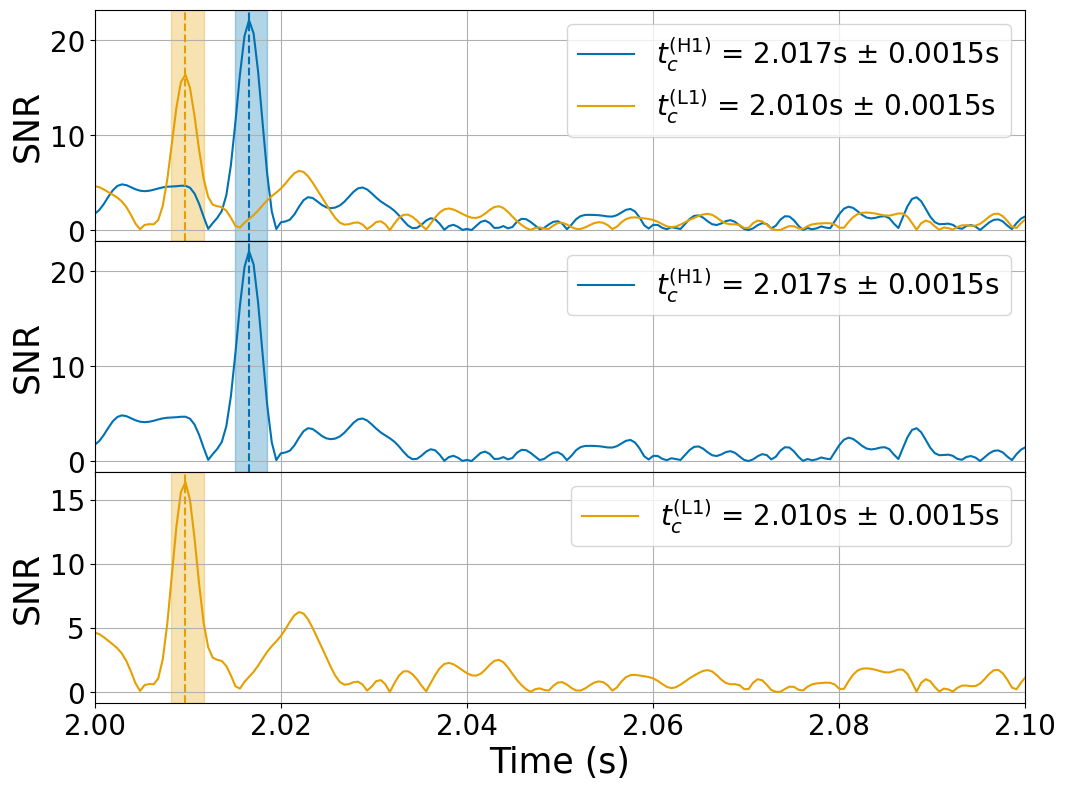

In [153]:
snr_plots(time, [tc_H1, tc_L1], [sigma_H1, sigma_L1], [snr_H1, snr_L1], [t1_H1, t1_L1], [t2_H2, t2_L2], 'HL')

In [113]:
print(fr"TIME DELAY (H1-L1): {tc_H1-tc_L1:.4f} ± {np.sqrt(sigma_H1**2 + sigma_H1**2):.5f} s")

TIME DELAY (H1-L1): 0.0068 ± 0.00207 s


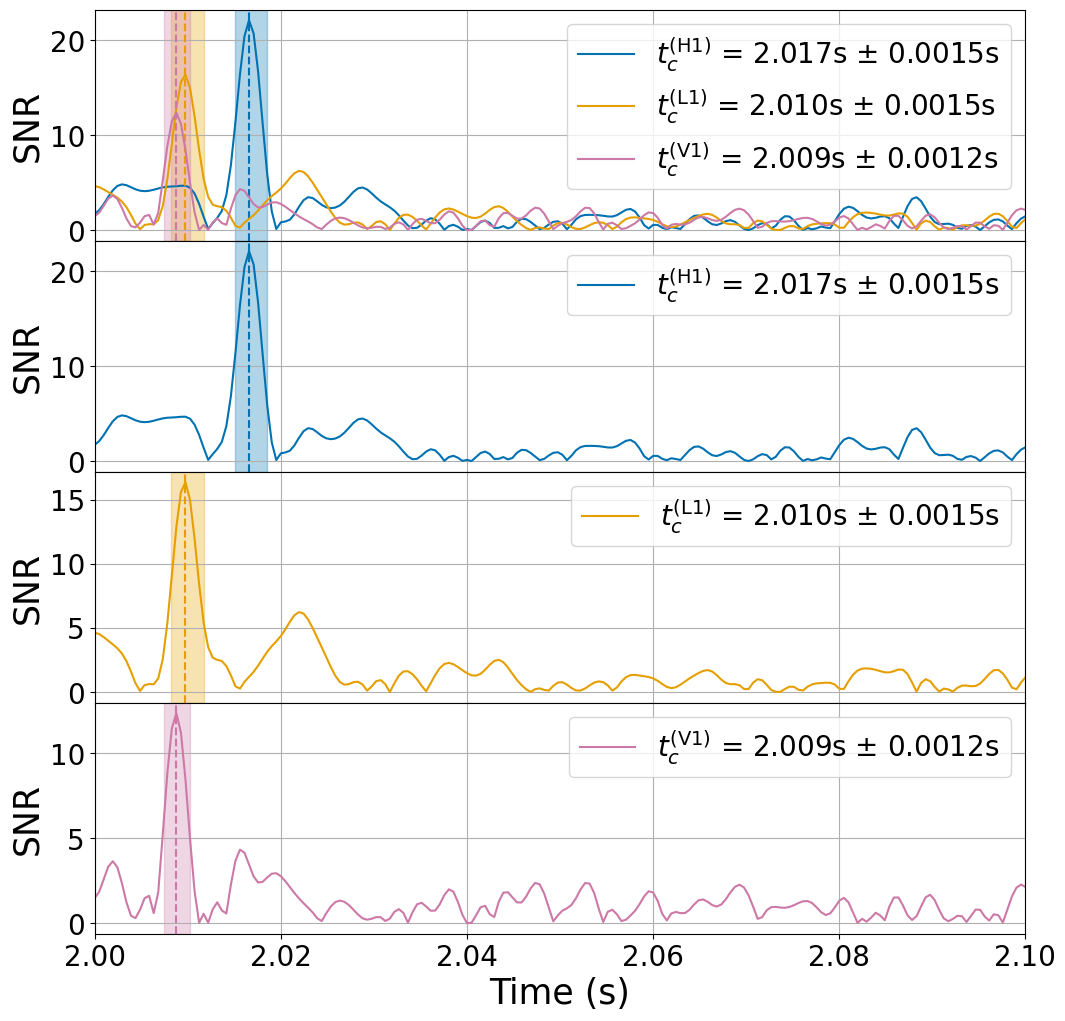

In [154]:
snr_plots(time, [tc_H1, tc_L1, tc_V1],
          [sigma_H1, sigma_L1, sigma_V1],
          [snr_H1, snr_L1, snr_V1],
          [t1_H1, t1_L1, t1_V1],
          [t2_H2, t2_L2, t2_V2], 'HLV')

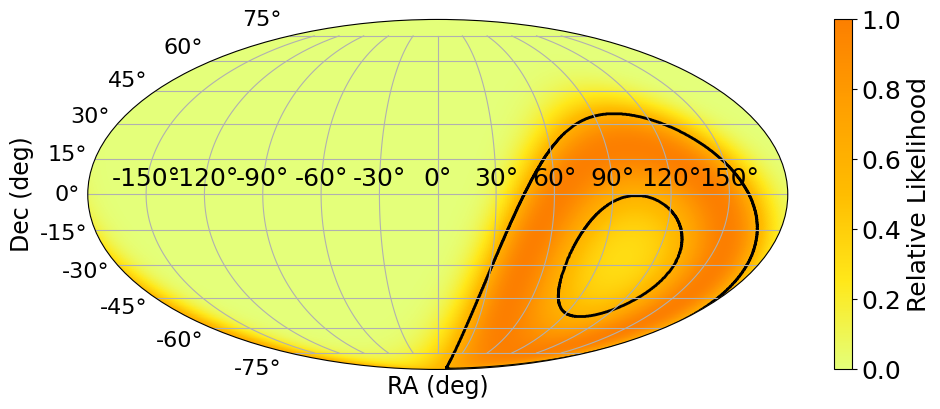

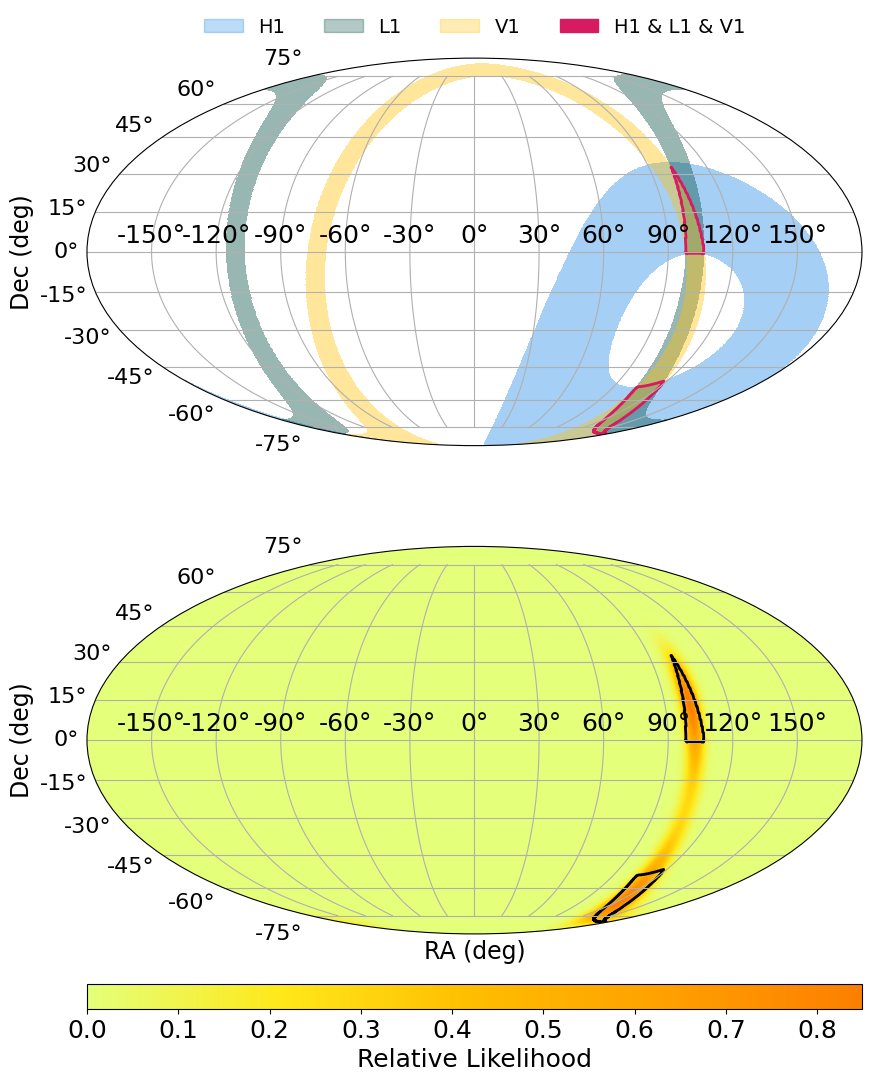

In [102]:
dts = [tc_H1-tc_L1, tc_H1-tc_V1, tc_L1-tc_V1]
sigmas = [np.sqrt(sigma_H1**2 + sigma_L1**2), np.sqrt(sigma_H1**2 + sigma_V1**2), np.sqrt(sigma_L1**2 + sigma_V1**2)]

get_plots(time_delays_HLV, dts, sigmas)